Hackstory ML

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from fairlearn.reductions import GridSearch, DemographicParity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


In [209]:
rawdata = pd.read_csv('income_train.csv') 

In [210]:
rawdata = rawdata.drop(['signature_id', 'capital-gain', 'capital-loss'], axis=1)


In [211]:
rawdata.replace('?', np.nan, inplace=True)


for column in rawdata.columns:
    if rawdata[column].isnull().sum() > 0:
        if rawdata[column].dtype == 'object':
            mode = rawdata[column].mode()[0]
            rawdata[column].fillna(mode, inplace=True)
        else:
            mean = rawdata[column].mean()
            rawdata[column].fillna(mean, inplace=True)

rawdata.to_csv('updated_dataset.csv', index=False)

In [212]:
label_encoder = LabelEncoder()

# Encode "education" column
rawdata['education_encoded'] = label_encoder.fit_transform(rawdata['education']) + 1
rawdata.to_csv('updated_dataset.csv', index=False)


In [213]:
data = pd.read_csv('updated_dataset.csv')

# Biases Analysis - Race
race_counts = data['race'].value_counts()
race_percentages = race_counts / len(data) * 100
print("Race Distribution:")
print(race_percentages)

# Biases Analysis - Gender
gender_counts = data['gender'].value_counts()
gender_percentages = gender_counts / len(data) * 100
print("\nGender Distribution:")
print(gender_percentages)

# Biases Analysis - Native Country
country_counts = data['native-country'].value_counts()
country_percentages = country_counts / len(data) * 100
print("\nNative Country Distribution:")
print(country_percentages)

Race Distribution:
White                 85.425563
Black                  9.631471
Asian-Pac-Islander     3.112021
Amer-Indian-Eskimo     0.956420
Other                  0.874525
Name: race, dtype: float64

Gender Distribution:
Male      68.046212
Female    31.953788
Name: gender, dtype: float64

Native Country Distribution:
United-States                 91.485815
Mexico                         1.956712
Philippines                    0.608365
Germany                        0.412401
Puerto-Rico                    0.386078
Canada                         0.353905
El-Salvador                    0.324656
India                          0.321732
Cuba                           0.289558
China                          0.266160
England                        0.245686
South                          0.225212
Jamaica                        0.222287
Italy                          0.213513
Columbia                       0.204738
Dominican-Republic             0.201813
Poland                         0.

In [214]:
data['educational-num'] = pd.to_numeric(data['educational-num'], errors='coerce')

average = data['educational-num'].mean()

data['educational-num'].fillna(average, inplace=True)
data.to_csv('updated_dataset.csv', index=False)

In [215]:
print(data.describe())

                age        fnlwgt  educational-num  hours-per-week  \
count  34190.000000  3.419000e+04     34190.000000    34190.000000   
mean      38.423252  1.890983e+05        10.064208       40.431325   
std       13.693060  1.054741e+05         2.426112       12.369751   
min       17.000000  1.228500e+04         1.000000        1.000000   
25%       28.000000  1.170412e+05         9.000000       40.000000   
50%       37.000000  1.779070e+05        10.000000       40.000000   
75%       47.000000  2.368610e+05        11.000000       45.000000   
max       90.000000  1.490400e+06        16.000000       99.000000   

       education_encoded  
count       34190.000000  
mean           11.284469  
std             3.886682  
min             1.000000  
25%            10.000000  
50%            12.000000  
75%            13.000000  
max            16.000000  


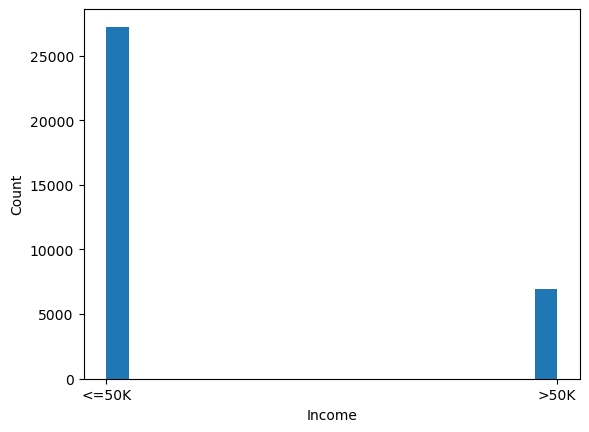

In [216]:
plt.hist(data['income'], bins=20)
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()


In [217]:
X = data.drop('income', axis=1)
y = data['income']
data_encoded = pd.get_dummies(data, columns=['workclass'])

In [218]:
X = data.drop('income', axis=1)
y = data['income']

categorical_cols = ['workclass'] 
encoder = ColumnTransformer(
    [('encoder', OneHotEncoder(sparse_output=False, drop='first'), categorical_cols)],
    remainder='passthrough'
)
X_encoded = pd.DataFrame(encoder.fit_transform(X))
X_encoded.columns = encoder.get_feature_names_out()
X = X_encoded

In [219]:
X = data.drop('income', axis=1)
y = data['income']

label_encoder = LabelEncoder()
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = label_encoder.fit_transform(X[column])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [220]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [222]:
X = data.drop(['income'], axis=1)
y = data['income']

label_encoder = LabelEncoder()
X_encoded = X.apply(label_encoder.fit_transform)
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

constraint = DemographicParity()

gender_index = list(X.columns).index('gender')

grid_search = GridSearch(classifier, constraint)
grid_search.fit(X_train, y_train, sensitive_features=X_train[:, gender_index])

y_pred = grid_search.predict(X_test)

In [223]:
X = data.drop(['income'], axis=1)
y = data['income']

label_encoder = LabelEncoder()
X_encoded = X.apply(label_encoder.fit_transform)
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

constraint = DemographicParity()

race_index = list(X.columns).index('race')

grid_search = GridSearch(classifier, constraint)
grid_search.fit(X_train, y_train, sensitive_features=X_train[:, race_index])

y_pred = grid_search.predict(X_test)

Generating a grid with 10 grid points. It is recommended to use at least 16 grid points. Please consider increasing grid_size.


In [224]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [225]:
y_pred = model.predict(X_test)

In [226]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.4f}%')

Accuracy: 82.4949%


In [227]:
df = pd.read_csv('updated_dataset.csv')

X = df.drop(['income'], axis=1)
y = df['income']

# Compute weights based on 'fnlwgt'
weights = X['fnlwgt'] / X['fnlwgt'].sum()

label_encoder = LabelEncoder()
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = label_encoder.fit_transform(X[column])

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
sample_weights_resampled, _ = smote.fit_resample(weights.to_frame(), y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
sample_weights_train, sample_weights_test = train_test_split(sample_weights_resampled, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train, sample_weight=sample_weights_train.values.ravel())

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy considering final weights: {accuracy * 100:.4f}%')

Accuracy considering final weights: 88.5717%


In [228]:
import pickle
pickle_out = open("model.pkl","wb")
pickle.dump(model, pickle_out)
pickle_out.close()